<a href="https://colab.research.google.com/github/leman-cap13/DL_projects/blob/main/Traffic_Sign_Recognition_Description.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CNN Model

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (4).json


{'kaggle (4).json': b'{"username":"lmanqasml","key":"2d851a4eb9cae06770577185722326e0"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
gtsrb-german-traffic-sign.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import zipfile

In [5]:
with zipfile.ZipFile('/content/gtsrb-german-traffic-sign.zip','r') as zip_ref:
  zip_ref.extractall()

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [7]:
train_dir='/content/train'
test_dir='/content/test'
img_size=(224,224)

In [8]:
import os

In [9]:
!ls /content/train

0   11	14  17	2   22	25  28	30  33	36  39	41  6  9
1   12	15  18	20  23	26  29	31  34	37  4	42  7
10  13	16  19	21  24	27  3	32  35	38  40	5   8


In [10]:
train_data=tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=32,
    subset='training',
    validation_split=0.2,
    seed=42
)

valid_data=tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=32,
    subset='validation',
    validation_split=0.2,
    seed=42
)



Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


In [12]:
# train_ds = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)
# train_ds = train_ds.shuffle(1000).prefetch(tf.data.AUTOTUNE)
# val_ds = valid_data.prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
#Prefetch is used in tf.data pipelines to overlap data preparation (CPU) with model training (GPU/TPU) so the accelerator never waits for data.
# Loads the next batch of data while the model is training on the current batch.
# Eliminates idle time for the GPU/TPU.
# Improves training speed, especially with slow storage or heavy preprocessing.

In [14]:
# Buffer Size
# Definition: How many batches to keep ready in memory ahead of training.
# Large buffer size → more batches ready → less waiting, but uses more RAM.
# Small buffer size → less memory usage, but might cause GPU idle time.

In [15]:
# In case test_data  is a DirectoryIterator from ImageDataGenerator (old Keras API), which does not support .prefetch().


In [11]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
])

In [13]:
class_names = train_data.class_names
print(len(class_names))

43


In [14]:
for image, label in train_data.take(1):
  print(image.shape)
  print(label.shape)
  print(label.numpy())

(32, 224, 224, 3)
(32,)
[34 25 32  6  4 25 12  5 41 21  2  5 32  5  4 34  4 26 41  4 34 32 35  5
 26 21 34  5 10  5  5 38]


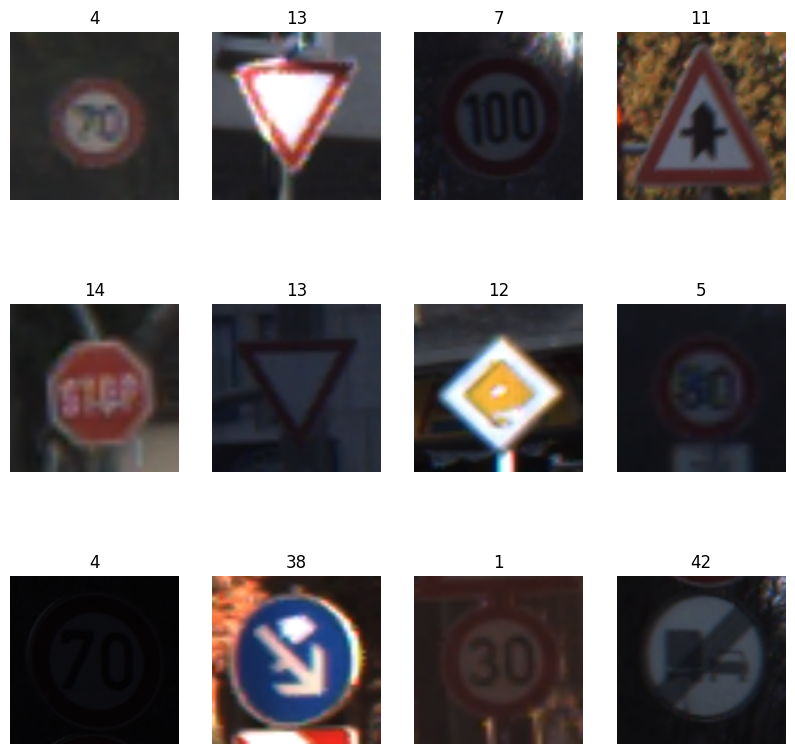

In [15]:
plt.figure(figsize=(10, 10))
for images,labes in train_data.take(1):
  for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labes[i]])
    plt.axis("off")
plt.show()

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Rescaling(1./255),
    data_augmentation,
    tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=43, activation='softmax')
])


In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True)

In [18]:
initial_learning_rate = 0.001
lr_schedule=tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.9,
    staircase=True
)

In [23]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=['accuracy']
)

In [24]:
model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stopping]
    )

In [19]:
#transfer learning
inputs=tf.keras.layers.Input(shape=(224,224,3),name='input_layer')


x=tf.keras.layers.Resizing(224,224)(inputs)
x=data_augmentation(x)



x=tf.keras.applications.xception.preprocess_input(inputs)
base_model = tf.keras.applications.xception.Xception(
    include_top=False,
    weights='imagenet',
    input_tensor=x
)

base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False


avg=tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x=tf.keras.layers.Dense(256,activation='relu',kernel_initializer='he_normal')(avg)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dense(128,activation='relu',kernel_initializer='he_normal')(x)
x=tf.keras.layers.BatchNormalization()(x)
output=tf.keras.layers.Dense(43,activation='softmax')(x)


transformer_model=tf.keras.Model(inputs=inputs,outputs=output)

transformer_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=['accuracy']
)

transformer_model.fit(
    train_data,
    epochs=10,
    validation_data=valid_data,
    callbacks=[early_stopping]
    )

Epoch 1/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 261s 240ms/step - accuracy: 0.8167 - loss: 0.6905 - val_accuracy: 0.9897 - val_loss: 0.0329
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 237s 231ms/step - accuracy: 0.9945 - loss: 0.0231 - val_accuracy: 0.9980 - val_loss: 0.0072
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 251s 220ms/step - accuracy: 0.9993 - loss: 0.0041 - val_accuracy: 0.9982 - val_loss: 0.0050
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 262s 220ms/step - accuracy: 0.9999 - loss: 0.0015 - val_accuracy: 0.9987 - val_loss: 0.0046
Epoch 5/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 262s 220ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9987 - val_loss: 0.0046
Epoch 6/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 226s 230ms/step - accuracy: 0.9998 - loss: 0.0012 - val_accuracy: 0.9987 - val_loss: 0.0043
Epoch 7/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 226s 230ms/step - accuracy: 1.0000 - loss: 9.9437e-04 - val_accuracy: 0.9987 - val_loss: 0.0042
Epoch 8/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 226s 230ms/step - accuracy: 1.00

In [20]:
import numpy as np


pred_probs = transformer_model.predict(valid_data)


pred_labels = np.argmax(pred_probs, axis=1)


true_labels = np.concatenate([y for x, y in valid_data], axis=0)


246/246 ━━━━━━━━━━━━━━━━━━━━ 38s 142ms/step


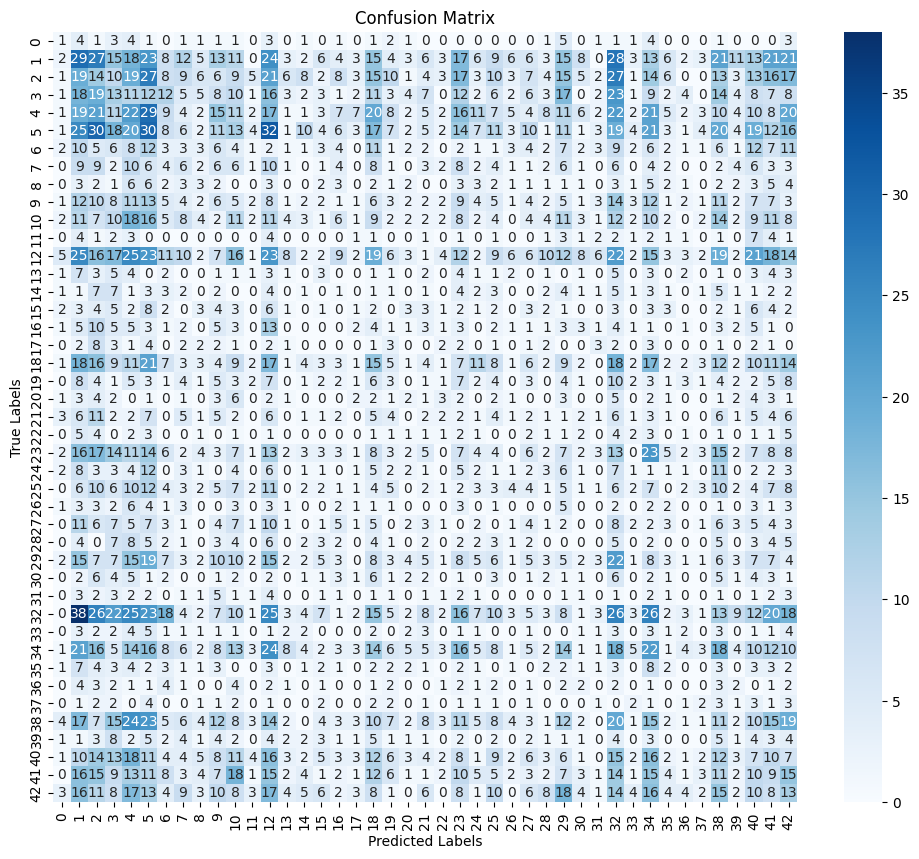

              precision    recall  f1-score   support

           0       0.02      0.02      0.02        44
           1       0.06      0.06      0.06       448
          10       0.04      0.04      0.04       390
          11       0.04      0.04      0.04       297
          12       0.06      0.06      0.06       396
          13       0.07      0.07      0.07       441
          14       0.02      0.02      0.02       173
          15       0.04      0.04      0.04       146
          16       0.04      0.04      0.04        82
          17       0.03      0.03      0.03       206
          18       0.04      0.04      0.04       248
          19       0.00      0.00      0.00        46
           2       0.05      0.05      0.05       429
          20       0.01      0.01      0.01        67
          21       0.01      0.01      0.01        75
          22       0.01      0.01      0.01        89
          23       0.00      0.00      0.00        98
          24       0.00    

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


print(classification_report(true_labels, pred_labels, target_names=class_names))


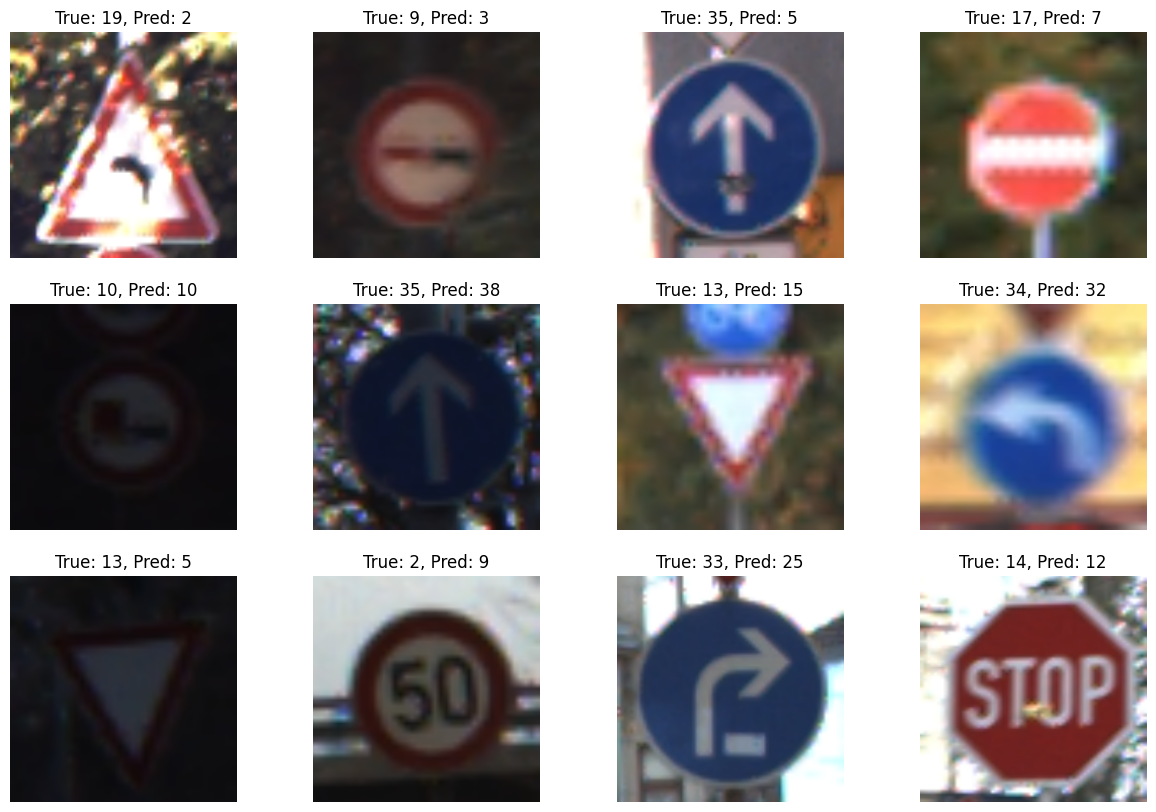

In [22]:
misclassified_idx = np.where(pred_labels != true_labels)[0]

plt.figure(figsize=(15,10))
for i, idx in enumerate(misclassified_idx[:12]):  # first 12 misclassified
    images, labels = list(valid_data.unbatch())[idx]
    plt.subplot(3, 4, i+1)
    plt.imshow(images.numpy().astype("uint8"))
    plt.title(f"True: {class_names[labels]}, Pred: {class_names[pred_labels[idx]]}")
    plt.axis("off")
plt.show()


In [23]:
history = transformer_model.fit(
    train_data,
    epochs=4,
    validation_data=valid_data,
    callbacks=[early_stopping]
)


Epoch 1/4
981/981 ━━━━━━━━━━━━━━━━━━━━ 226s 230ms/step - accuracy: 1.0000 - loss: 8.9704e-04 - val_accuracy: 0.9987 - val_loss: 0.0041
Epoch 2/4
981/981 ━━━━━━━━━━━━━━━━━━━━ 214s 218ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9987 - val_loss: 0.0041
Epoch 3/4
981/981 ━━━━━━━━━━━━━━━━━━━━ 262s 218ms/step - accuracy: 0.9999 - loss: 0.0011 - val_accuracy: 0.9987 - val_loss: 0.0041
Epoch 4/4
981/981 ━━━━━━━━━━━━━━━━━━━━ 273s 229ms/step - accuracy: 1.0000 - loss: 9.6832e-04 - val_accuracy: 0.9987 - val_loss: 0.0041


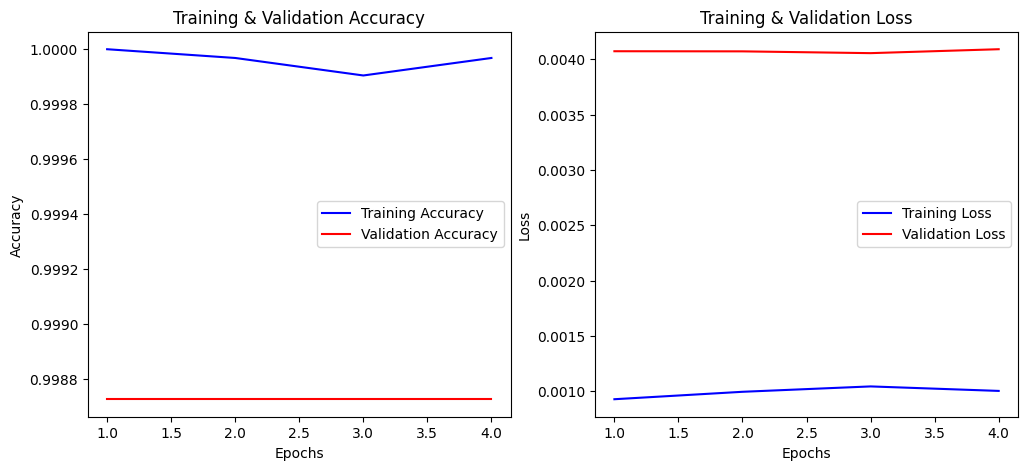

In [24]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [27]:
transformer_model.save("/content/transformer_model.keras")
